In [1]:
import os
import tensorflow as tf
import malaya
import json
import matplotlib.pyplot as plt

In [2]:
import re

tokenizer = malaya.preprocessing._SocialTokenizer().tokenize

def is_number_regex(s):
    if re.match("^\d+?\.\d+?$", s) is None:
        return s.isdigit()
    return True

def detect_money(word):
    if word[:2] == 'rm' and is_number_regex(word[2:]):
        return True
    else:
        return False

def preprocessing(string):
    tokenized = tokenizer(string)
    tokenized = [malaya.stem.naive(w) for w in tokenized]
    tokenized = [w.lower() for w in tokenized if len(w) > 1]
    tokenized = ['<NUM>' if is_number_regex(w) else w for w in tokenized]
    tokenized = ['<MONEY>' if detect_money(w) else w for w in tokenized]
    return tokenized

def clean_label(label):
    string = re.sub('[^A-Za-z\- ]+', ' ', label)
    return re.sub(r'[ ]+', ' ', string.lower()).strip()

In [3]:
with open('augmented-relevancy.json') as fopen:
    loaded = json.load(fopen)
    
X = loaded['X']
Y = loaded['Y']
del loaded
del X

In [4]:
len(Y)

209519

In [5]:
with open('tokenized.json') as fopen:
    X = json.load(fopen)
len(X)

209519

In [6]:
with open('relevancy-dictionary.json') as fopen:
    data = json.load(fopen)
dictionary = data['dictionary']
rev_dictionary = data['reverse_dictionary']

In [7]:
import numpy as np

In [8]:
def position_encoding(inputs):
    T = tf.shape(inputs)[1]
    repr_dim = inputs.get_shape()[-1].value
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1])

def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    return gamma * normalized + beta

def Attention(inputs, num_units, num_heads = 8, activation = None):
    inputs = tf.layers.dropout(inputs, 0.3, training=True)
    T_q = T_k = tf.shape(inputs)[1]
    Q_K_V = tf.layers.dense(inputs, 3*num_units, activation)
    Q, K, V = tf.split(Q_K_V, 3, -1)
    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), 0)
    K_ = tf.concat(tf.split(K, num_heads, axis=2), 0)
    V_ = tf.concat(tf.split(V, num_heads, axis=2), 0)
    align = tf.matmul(Q_, K_, transpose_b=True)
    align *= tf.rsqrt(tf.to_float(K_.get_shape()[-1].value))
    paddings = tf.fill(tf.shape(align), float('-inf'))
    lower_tri = tf.ones([T_q, T_k])
    lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()
    masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0],1,1])
    align = tf.where(tf.equal(masks, 0), paddings, align)
    align = tf.nn.softmax(align)
    alignments = tf.transpose(align, [0, 2, 1]) 
    x = tf.matmul(align, V_)
    x = tf.concat(tf.split(x, num_heads, axis=0), 2)
    x += inputs
    x = layer_norm(x)
    return x, alignments

class Model:
    def __init__(self, size_layer, embed_size, dict_size, dimension_output, learning_rate = 1e-3):
        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None])
        
        encoder_embeddings = tf.Variable(tf.random_uniform([dict_size, embed_size], -1, 1))
        x = tf.nn.embedding_lookup(encoder_embeddings, self.X)
        x += position_encoding(x)
        x = tf.layers.dropout(x, 0.3, training=True) 
        
        x, self.alignments = Attention(x, size_layer)
        self.logits_seq = tf.layers.dense(x, dimension_output)
        self.logits_seq = tf.identity(self.logits_seq, name = 'logits_seq')
        self.logits = self.logits_seq[:,-1]
        self.logits = tf.identity(self.logits, name = 'logits')

        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = self.logits, labels = self.Y
            )
        )
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        correct_pred = tf.equal(
            tf.argmax(self.logits, 1, output_type = tf.int32), self.Y
        )
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        self.attention = tf.identity(tf.reduce_mean(self.alignments[0], 1), name = 'alphas')

In [9]:
size_layer = 256
dimension_output = 2
learning_rate = 1e-4
batch_size = 8
maxlen = 500

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(
    size_layer,
    size_layer,
    len(dictionary),
    dimension_output,
    learning_rate,
)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'only-attention/model.ckpt')

'only-attention/model.ckpt'

In [10]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or 'logits' in n.name
        or 'logits_seq' in n.name
        or 'alphas' in n.name)
        and 'Adam' not in n.name
        and '_power' not in n.name
    ]
)
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Variable',
 'dense/kernel',
 'dense/bias',
 'gamma',
 'beta',
 'dense_1/kernel',
 'dense_1/bias',
 'logits_seq',
 'logits',
 'alphas']

In [11]:
def str_idx(corpus, dic, maxlen, UNK = 3):
    X = np.zeros((len(corpus), maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i][:maxlen]):
            X[i, no] = dic.get(k, UNK)
    return X

In [12]:
from sklearn.cross_validation import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.2)

del X, Y

In [13]:
len(train_X), len(test_X)

(167615, 41904)

In [14]:
max_x = maxlen

In [21]:
from tqdm import tqdm
import time

for EPOCH in range(5):
    lasttime = time.time()

    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        index = min(i + batch_size, len(train_X))
        batch_x = train_X[i : index]
        batch_y = train_Y[i : index]
        max_batch = max([len(x) for x in batch_x])
        max_batch = min(max_batch, max_x)
        batch_x = str_idx(batch_x, dictionary, max_batch)
        
        acc, cost, _ = sess.run(
            [model.accuracy, model.cost, model.optimizer],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        assert not np.isnan(cost)
        train_loss += cost
        train_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)
    
    pbar = tqdm(
        range(0, len(test_X), batch_size), desc = 'test minibatch loop'
    )
    for i in pbar:
        index = min(i + batch_size, len(test_X))
        batch_x = test_X[i : index]
        batch_y = test_Y[i : index]
        max_batch = max([len(x) for x in batch_x])
        max_batch = min(max_batch, max_x)
        batch_x = str_idx(batch_x, dictionary, max_batch)
        
        acc, cost = sess.run(
            [model.accuracy, model.cost],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x,
            },
        )
        assert not np.isnan(cost)
        test_loss += cost
        test_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)
    
    train_loss /= len(train_X) / batch_size
    train_acc /= len(train_X) / batch_size
    test_loss /= len(test_X) / batch_size
    test_acc /= len(test_X) / batch_size
        
    print('time taken:', time.time() - lasttime)
    print(
        'epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n'
        % (EPOCH, train_loss, train_acc, test_loss, test_acc)
    )

train minibatch loop:   0%|          | 2/20952 [00:00<33:21, 10.47it/s, accuracy=0.875, cost=0.116]

time taken: 2114.485299348831
epoch: 0, training loss: 0.244375, training acc: 0.899072, valid loss: 0.248877, valid acc: 0.897862



train minibatch loop:   0%|          | 2/20952 [00:00<33:30, 10.42it/s, accuracy=1, cost=0.113]

time taken: 2114.692099094391
epoch: 1, training loss: 0.222622, training acc: 0.908278, valid loss: 0.227713, valid acc: 0.906691



train minibatch loop:   0%|          | 2/20952 [00:00<33:28, 10.43it/s, accuracy=1, cost=0.087]

time taken: 2114.9458503723145
epoch: 2, training loss: 0.202837, training acc: 0.916654, valid loss: 0.216099, valid acc: 0.912037



train minibatch loop:  74%|███████▍  | 15492/20952 [24:43<08:44, 10.42it/s, accuracy=0.75, cost=0.348]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train minibatch loop:   0%|          | 2/20952 [00:00<33:21, 10.46it/s, accuracy=0.875, cost=0.204]

time taken: 2116.475646018982
epoch: 3, training loss: 0.188361, training acc: 0.922996, valid loss: 0.208490, valid acc: 0.916189



test minibatch loop: 100%|██████████| 5238/5238 [01:48<00:00, 48.32it/s, accuracy=0.875, cost=0.348] 

time taken: 2114.261835336685
epoch: 4, training loss: 0.172600, training acc: 0.930239, valid loss: 0.194194, valid acc: 0.923015



In [39]:
testing = 'Sesungguhnya menjadi tradisi, mana-mana calon presiden AS pasti perlu mendapat sokongan masyarakat Yahudi yang mengawal ekonomi di AS untuk jadi presiden, namun tidak ramai seberani Trump dalam mengotakan dan mengabui mata Yahudi dan Zionism Israel'
testing = preprocessing(testing)
t = testing
testing = str_idx([testing], dictionary, len(testing))

In [40]:
t

['sesungguh',
 'jadi',
 'tradisi',
 'mana',
 'mana',
 'calon',
 'presiden',
 'as',
 'pasti',
 'lu',
 'dapat',
 'sokong',
 'masyarakat',
 'yahudi',
 'yang',
 'awal',
 'ekonomi',
 'as',
 'untuk',
 'jadi',
 'presiden',
 'namun',
 'tidak',
 'ramai',
 'berani',
 'trump',
 'dalam',
 'ota',
 'abui',
 'mata',
 'yahudi',
 'zionism',
 'israel']

In [41]:
b, c, d = sess.run([tf.nn.softmax(model.logits), tf.nn.softmax(model.logits_seq), model.attention], 
                    feed_dict = {model.X: testing})

In [42]:
b

array([[0.9926528 , 0.00734717]], dtype=float32)

In [43]:
c

array([[[9.99721348e-01, 2.78680644e-04],
        [9.97851491e-01, 2.14848598e-03],
        [8.84962380e-01, 1.15037575e-01],
        [9.95472968e-01, 4.52698302e-03],
        [1.82360321e-01, 8.17639709e-01],
        [4.80056554e-02, 9.51994359e-01],
        [9.75962460e-01, 2.40375232e-02],
        [9.92748916e-01, 7.25105964e-03],
        [9.91550803e-01, 8.44925363e-03],
        [9.80649114e-01, 1.93508845e-02],
        [9.50576782e-01, 4.94232401e-02],
        [9.73492444e-01, 2.65075620e-02],
        [9.89429057e-01, 1.05709629e-02],
        [9.90319610e-01, 9.68041457e-03],
        [9.96597826e-01, 3.40218726e-03],
        [8.83741081e-01, 1.16258942e-01],
        [9.93655801e-01, 6.34427927e-03],
        [9.87958789e-01, 1.20412484e-02],
        [9.00432646e-01, 9.95673686e-02],
        [9.73192155e-01, 2.68078055e-02],
        [9.72041488e-01, 2.79585067e-02],
        [9.51479554e-01, 4.85204719e-02],
        [8.65876317e-01, 1.34123728e-01],
        [9.30201590e-01, 6.9798454

In [44]:
d

array([0.19861771, 0.0379051 , 0.06074551, 0.02474108, 0.05489456,
       0.07222023, 0.09342257, 0.07365928, 0.05689906, 0.05350484,
       0.02639626, 0.0181087 , 0.0213936 , 0.02086836, 0.00993358,
       0.03435629, 0.01645491, 0.02005102, 0.01218155, 0.00834859,
       0.0077991 , 0.00710016, 0.01192109, 0.0039927 , 0.01081928,
       0.00631195, 0.01106844, 0.00624675, 0.01189933, 0.00441268,
       0.00183982, 0.00095971, 0.00092618], dtype=float32)

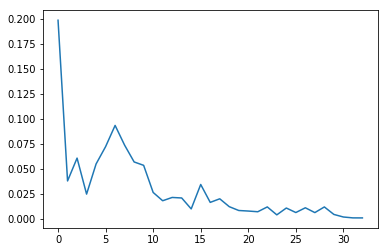

In [45]:
plt.plot(d)
plt.show()

In [46]:
saver.save(sess, 'only-attention/model.ckpt')

'only-attention/model.ckpt'

In [47]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [48]:
freeze_graph('only-attention', strings)

INFO:tensorflow:Restoring parameters from only-attention/model.ckpt
INFO:tensorflow:Froze 7 variables.
INFO:tensorflow:Converted 7 variables to const ops.
248 ops in the final graph.


In [49]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [50]:
g = load_graph('only-attention/frozen_model.pb')

In [51]:
x = g.get_tensor_by_name('import/Placeholder:0')
logits = g.get_tensor_by_name('import/logits:0')
logits_seq = g.get_tensor_by_name('import/logits_seq:0')
alphas = g.get_tensor_by_name('import/alphas:0')

In [52]:
test_sess = tf.InteractiveSession(graph = g)
result = test_sess.run([tf.nn.softmax(logits), tf.nn.softmax(logits_seq),
                       alphas], feed_dict = {x: testing})

In [53]:
result[0]

array([[0.7628296 , 0.23717038]], dtype=float32)

In [54]:
result[1]

array([[[0.38231325, 0.61768675],
        [0.01519727, 0.9848028 ],
        [0.14517567, 0.8548243 ],
        [0.80922496, 0.19077502],
        [0.9147201 , 0.08527987],
        [0.89138526, 0.10861477],
        [0.83451647, 0.16548353],
        [0.9606083 , 0.03939165],
        [0.9363214 , 0.06367864],
        [0.9454973 , 0.05450267],
        [0.98516786, 0.01483216],
        [0.9877473 , 0.01225268],
        [0.92698395, 0.073016  ],
        [0.9687949 , 0.03120516],
        [0.9687706 , 0.03122938],
        [0.87564087, 0.12435912],
        [0.83309096, 0.16690905],
        [0.85647386, 0.14352614],
        [0.62920225, 0.37079775],
        [0.7079018 , 0.2920982 ],
        [0.7158209 , 0.2841791 ],
        [0.8026356 , 0.19736437],
        [0.61922276, 0.3807772 ],
        [0.91943884, 0.08056109],
        [0.8085456 , 0.19145443],
        [0.81125504, 0.18874502],
        [0.8847513 , 0.11524865],
        [0.6478023 , 0.35219777],
        [0.94550276, 0.05449723],
        [0.899

In [55]:
result[2]

array([0.22430304, 0.04400339, 0.0867021 , 0.03677347, 0.02461758,
       0.06074273, 0.06958306, 0.03392227, 0.05117168, 0.0281567 ,
       0.02041283, 0.03219548, 0.03398983, 0.02006197, 0.00941218,
       0.02186522, 0.01930317, 0.01767851, 0.0202875 , 0.01673273,
       0.02446407, 0.0122072 , 0.00853015, 0.02017076, 0.01962015,
       0.00611633, 0.01035877, 0.00825041, 0.00631759, 0.00323242,
       0.00221459, 0.0018667 , 0.0047354 ], dtype=float32)